# Demystifying medical image prediction using Convolutional Neural Networks

In this example, we will look at what happens inside convolutional neural networks (CNN) and how does it make predictions in a medical context.

Agenda:

1. Use a publicly available [Brain Stroke CT Image Dataset](https://www.kaggle.com/datasets/afridirahman/brain-stroke-ct-image-dataset/data) from Kaggle. This dataset contains computed tomography (CT) images for "Normal" and "Stroke" classes.  
2. Build and train a basic CNN with two convolution layers and attempt to classify the images as either "Normal" or "Stroke".  
3. Compare the performance of the model before and after training.  
4. Visualise the output of each of the convolution layers (known as feature maps) to see what features the CNN model has learnt to be important through training.
5. Finally, use a [Grad-CAM](https://doi.org/10.48550/arXiv.1610.02391) to highlight important regions in the image for prediction.  

Tools used:
- Tensorflow ([link](https://www.tensorflow.org/))

Data used:
- [Brain Stroke CT Image Dataset](https://www.kaggle.com/datasets/afridirahman/brain-stroke-ct-image-dataset/data) from Kaggle  

In [1]:
# Load pre-requisites
import os
import tensorflow as tf
import numpy as np
from src.visualisation import plot_images, plot_predictions
from src.visualisation import plot_feature_maps, plot_gradcam

# Hide annoying warnings from Tensorflow
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"


In [2]:
# Working for 2.18.0
tf.__version__


'2.19.0'

## Step 1: Load dataset and apply preprocessing

Download the dataset from: Brain Stroke CT Image Dataset ([link](https://www.kaggle.com/datasets/afridirahman/brain-stroke-ct-image-dataset)). You may need to create a Kaggle account.

Unzip the dataset into `data/Brain_Data_Organised`. If you install it elsewhere, update the directory in the cell below.

In this cell, we:
1. Load the images in the dataset,
2. Check out the class names, and
3. Apply simple preprocessing by scaling the images values from 0-255 to 0-1.

In [3]:
# Load images
train_ds, validation_ds = tf.keras.utils.image_dataset_from_directory(
    directory="data/Brain_Data_Organised",
    labels="inferred",
    subset="both",
    validation_split=0.2,
    seed=42,
    shuffle=True,
    image_size=(224, 224),
    color_mode="grayscale",
    batch_size=32
)

# Get the class names
print("\nClass names are:")
class_names = train_ds.class_names
for i, class_name in enumerate(class_names):
    print(f"{i}-{class_name}")

# Apply pre-processing
# The values in the image range from 0-255.
# Standardise the data by rescaling between 0-1.
rescale = tf.keras.layers.Rescaling(1./255)
train_ds = (
    train_ds
    .map(lambda images, labels: (rescale(images), labels))
)
validation_ds = (
    validation_ds
    .map(lambda images, labels: (rescale(images), labels))
)


Found 2501 files belonging to 2 classes.
Using 2001 files for training.
Using 500 files for validation.

Class names are:
0-Normal
1-Stroke


I0000 00:00:1744183839.041988 4781084 pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
I0000 00:00:1744183839.042010 4781084 pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


## Step 2: View some images from the dataset

In this cell, we plot some examples of images from the dataset.

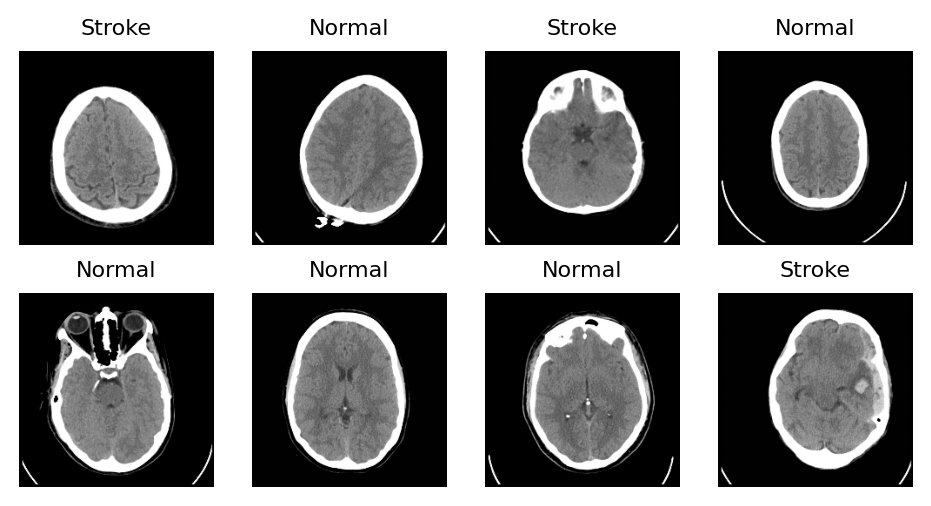

In [4]:
plot_images(
    dataset=train_ds,
    class_names=class_names
)


## What do we want to achieve?

In this section, we want to build an AI Model that can classify images as either "Normal" or "Stroke".




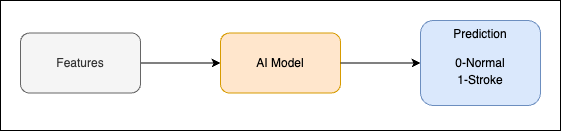

### Input

Certain characteristics of the images are helpful in classification. For example, these may be colours or shapes. These characteristics are known as **features**. The better our features, the better our ability to make accurate predictions.

### Output

We want our model to decide whether an image should be classified as **0-Normal** or **1-Stroke**. Our model achieves this by giving us a probability that the image belongs in either of the classes. We then select the class with the highest probability.

For example, the following output will result in a prediction of "Stroke":

| Class | Probability |
| -- | -- |
| 0-Normal | 0.1 |
| 1-Stroke | 0.9 |

## Step 4: Build and train a basic CNN model


How do we determine what parts of the images are helpful for our task?

Fortunately, in CNN, we can design our AI Model with convolution layers that allows the model to learn and extract the most helpful features.

Convolution layers achieve this by looking at our image through different "lenses", often referred to as kernels or filters. The layer learns the best type of "lens" to use during training.

If we use multiple filters, we can view the image through multiple "lenses", each giving us a slightly different perspective. In our model, we have defined two convolution layers, first with 32 filters and the second with 64 filters.

Feature maps are the output of the convolution layers after we apply these filters. Later, we will look at the feature maps to see what our model has discovered to be most helpful.



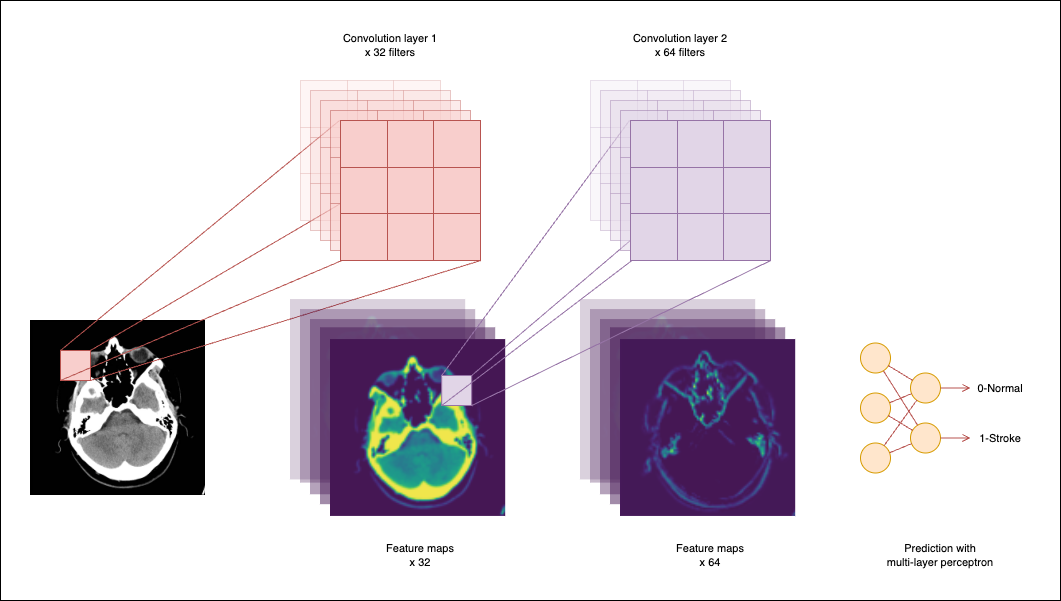

In [5]:
cnn_model = tf.keras.Sequential(
    name="basic_cnn_model",
    layers=[
        tf.keras.Input(shape=(224, 224, 1)),
        tf.keras.layers.Conv2D(
            filters=32,
            kernel_size=(3, 3),
            activation="relu",
            name="conv2d_0"
        ),
        tf.keras.layers.MaxPooling2D(
            pool_size=(2, 2)
        ),
        tf.keras.layers.Conv2D(
            filters=64,
            kernel_size=(3, 3),
            activation="relu",
            name="conv2d_1"
        ),
        tf.keras.layers.MaxPooling2D(
            pool_size=(2, 2)
        ),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(
            units=64,
            activation="relu"
        ),
        tf.keras.layers.Dense(
            units=2,
            activation="softmax"
        )
    ]
)

cnn_model.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"]
)
cnn_model(tf.keras.Input(shape=(224, 224, 1)))

cnn_model.summary()


Model: "basic_cnn_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_0 (Conv2D)               │ (None, 222, 222, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 186624)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │    11,944,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,962,946 (45.64 MB)

 Trainable params: 11,962,946 (45.64 MB)

 Non-trainable params: 0 (0.00 B)

## Step 5: Check performance before training

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


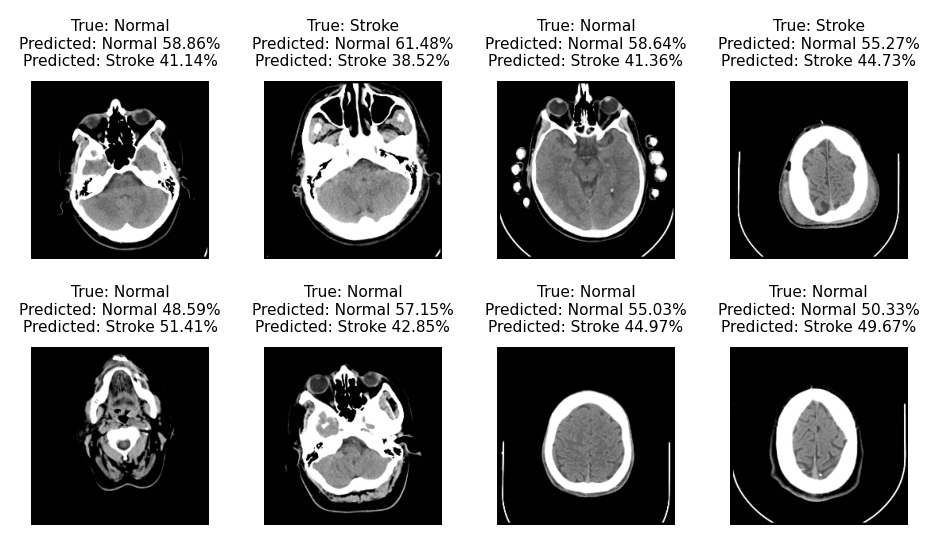

In [6]:
plot_predictions(
    dataset=validation_ds,
    class_names=class_names,
    model=cnn_model
)


## Step 6: Let's train the model

In [7]:
cnn_model.fit(
    x=train_ds,
    epochs=10
)


Epoch 1/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.5903 - loss: 1.5844
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.8281 - loss: 0.3923
Epoch 3/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9557 - loss: 0.1131
Epoch 4/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9886 - loss: 0.0458
Epoch 5/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9957 - loss: 0.0204
Epoch 6/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9967 - loss: 0.0142
Epoch 7/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 1.0000 - loss: 0.0051
Epoch 8/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 1.0000 - loss: 0.0013
Epoch 9/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 1.0000 - loss: 9.6349e-04
Epoch 10/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 1.0000 - loss: 4.8705e-04


## Step 7: Check performance after training

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


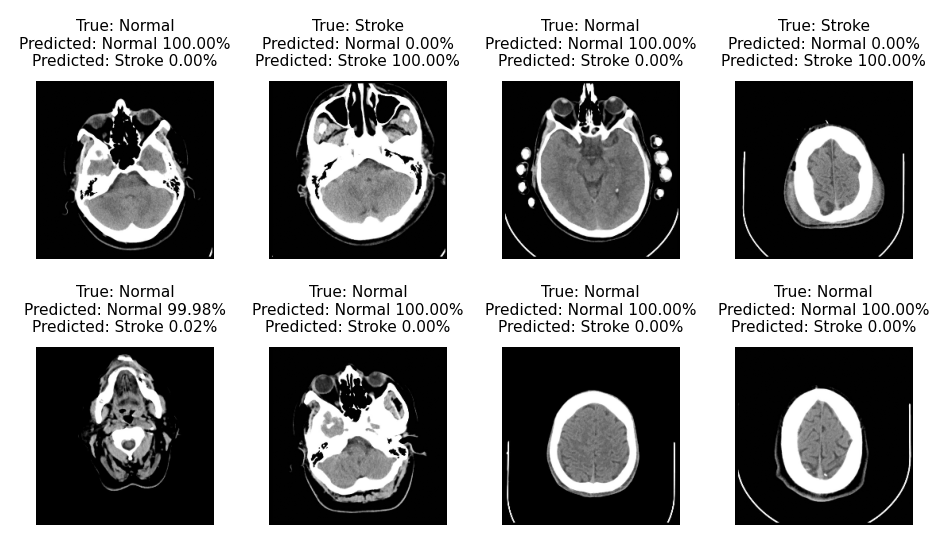

In [8]:
plot_predictions(
    dataset=validation_ds,
    class_names=class_names,
    model=cnn_model
)


## Step 8: Visualise feature maps

Feature maps are the output of Convolution Neural Network layers. We can visualise these feature maps to get a sense of what the model is trying discover from our images.

In [9]:
# Change this value to select different images
view_image_index = 0


In [10]:
# Generate feature map for an image
feature_maps_model = tf.keras.Model(
    inputs=cnn_model.inputs[0],
    outputs=[layer.output for layer in cnn_model.layers[:4]]
)

# Here, we select images from the first batch in the validation set
for images, labels in validation_ds.take(1):
    image = images[view_image_index]
    feature_maps = feature_maps_model.predict(image[tf.newaxis,])
    break


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


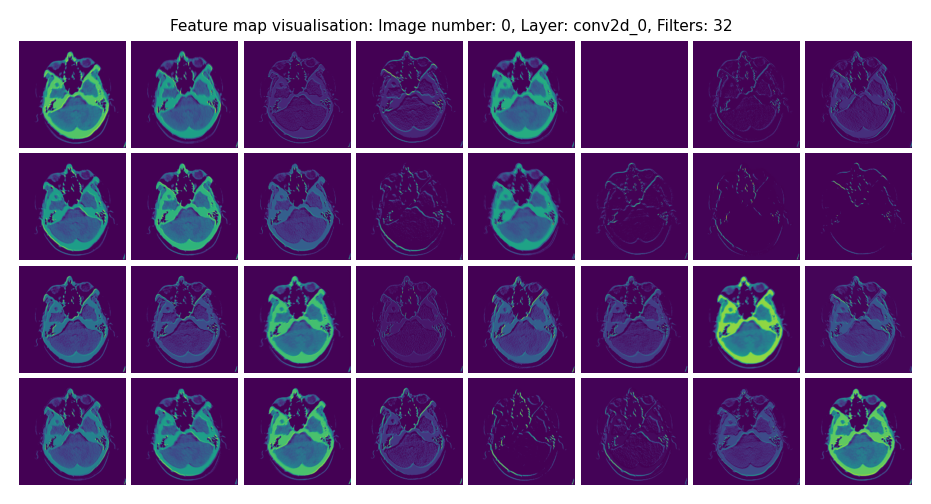

In [11]:
# Visualise feature map for the first convolution layer
plot_feature_maps(
    feature_maps=feature_maps,
    model=cnn_model,
    layer=0,
    image_number=view_image_index
)


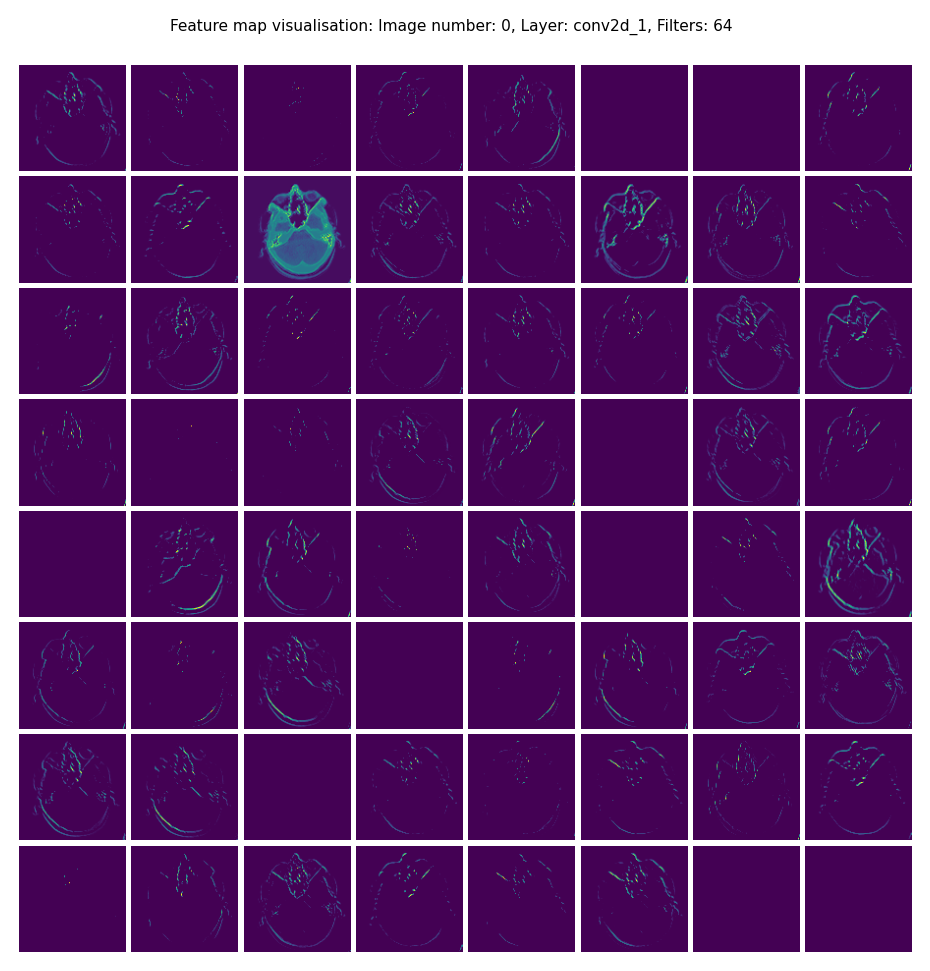

In [12]:
# Visualise feature map for the second convolution layer
plot_feature_maps(
    feature_maps=feature_maps,
    model=cnn_model,
    layer=2,
    image_number=view_image_index
)


## Step 9: Grad-CAM

Grad-CAM allows us to visualise which parts of the image are most important for classification.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


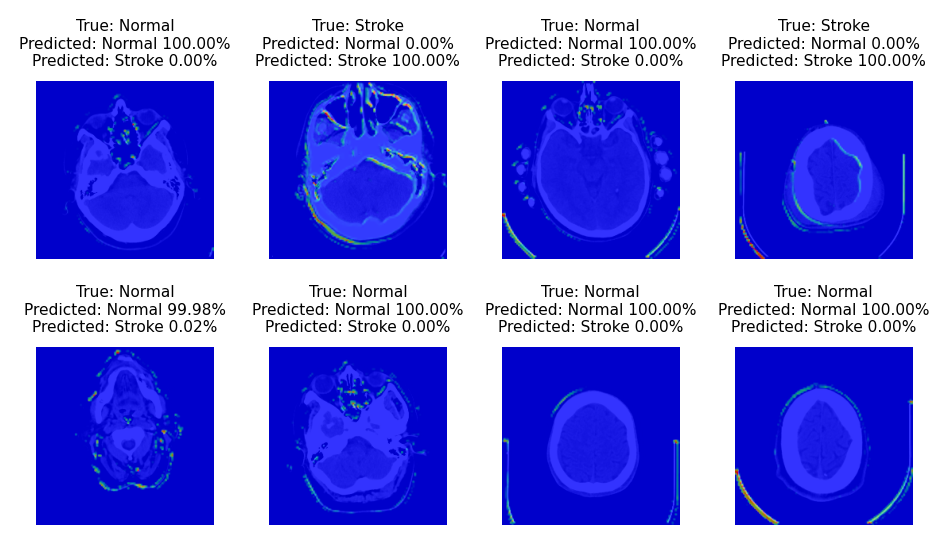

In [13]:
plot_gradcam(
    dataset=validation_ds,
    model=cnn_model,
    class_names=class_names
)
